# To help, or to work?

My intuition says that I should nearly always take an opportunity to help someone else improve their speed or quality of work, even with some short-term cost in my own output, because it improves the overall productivity *rate*. 🤔 An excellent question for an agent based model.
https://twitter.com/danielpcox/status/1557137305441280000

Here's the model:

- A population of agents has uniform random ability `0.5 <= ability <= 10.0`
- Agents walk around a grid of cells randomly each time step.
- At each time step, they also either "produce" their `ability` in work, or they "help" someone in the same cell with lower ability (if any), which improves the other's ability by 0.01.
- What proportion of the time they spend helping versus directly producing work is the key parameter of the model we're interested in at first.
- We'll keep a chart of overall work produced over time.
- We'll also track how everyone would do if they didn't help each other at all, for comparison.

In [680]:
%matplotlib inline

from statistics import mean
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector


## 'Employee' Agent

In [681]:
class Employee(Agent):
    def __init__(self, unique_id, model, max_ability, help_boost, help_prob):
        super().__init__(unique_id, model)
        self.max_ability = max_ability
        self.help_boost = help_boost
        self.help_prob = help_prob
        self.ability = (max_ability - 0.5) * model.random.random() + 0.5
        self.original_ability = self.ability
        print(f'Agent {unique_id} created with ability {self.ability:.2f}')

    def step(self):
        self._move()
        self._help_or_work()

    def _help_or_work(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        potential_help_recipients = [o for o in cellmates if o.ability < self.ability]

        if len(potential_help_recipients) > 0 and self.model.random.random() < self.help_prob:
            other = self.random.choice(potential_help_recipients)
            other.ability = min(self.max_ability, other.ability + self.help_boost)
        else: # otherwise just produce work according to your ability
            self.model.total_work_produced += self.ability

        # also interested in how we'd do if nobody helped
        self.model.total_work_produced_no_helping += self.original_ability

    def _move(self):
        neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=True)
        choice = self.random.choice(neighborhood)
        self.model.grid.move_agent(self, choice)

    def __str__(self):
        return f'[{type(self).__name__}#{self.unique_id} ability={self.ability}]'

## Model

In [682]:
class HelpOrWork(Model):
    def __init__(self, N, width, height, max_ability=2.0, help_boost=0.1, help_prob=0.5):
        self.N = N
        self.max_ability = max_ability
        self.help_prob = help_prob
        self.help_boost = help_boost
        self.total_work_produced = 0
        self.total_work_produced_no_helping = 0
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.running = True
        self.datacollector = DataCollector( model_reporters={
            "Work Produced": 'total_work_produced',
            "Work Produced (No Helping)": 'total_work_produced_no_helping',
            "Average Ability": lambda m: mean([a.ability for a in m.schedule.agents])
        })
        self.current_id = 0
        
        for _ in range(self.N):
            a = Employee(self.next_id(), self, max_ability, help_boost, help_prob)
            self.schedule.add(a)
            self.grid.place_agent(a, self.randpos())
            
    def randpos(self):
        x = self.random.randrange(self.grid.width)
        y = self.random.randrange(self.grid.height)
        return (x,y)
            
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

## Run it

In [683]:
model = HelpOrWork(N=80,
                   height=10,
                   width=10,
                   max_ability=2.0,
                   help_boost=0.1,
                   help_prob=1.0)

for i in range(100):
    model.step()

breakdown = model.datacollector.get_model_vars_dataframe()

Agent 1 created with ability 1.62
Agent 2 created with ability 1.94
Agent 3 created with ability 1.38
Agent 4 created with ability 0.70
Agent 5 created with ability 1.62
Agent 6 created with ability 0.54
Agent 7 created with ability 1.29
Agent 8 created with ability 1.40
Agent 9 created with ability 1.29
Agent 10 created with ability 1.16
Agent 11 created with ability 0.67
Agent 12 created with ability 1.87
Agent 13 created with ability 0.60
Agent 14 created with ability 0.63
Agent 15 created with ability 1.87
Agent 16 created with ability 1.45
Agent 17 created with ability 0.63
Agent 18 created with ability 0.63
Agent 19 created with ability 0.71
Agent 20 created with ability 0.70
Agent 21 created with ability 0.89
Agent 22 created with ability 1.60
Agent 23 created with ability 0.97
Agent 24 created with ability 0.55
Agent 25 created with ability 1.59
Agent 26 created with ability 1.68
Agent 27 created with ability 1.72
Agent 28 created with ability 0.95
Agent 29 created with ability

<AxesSubplot:>

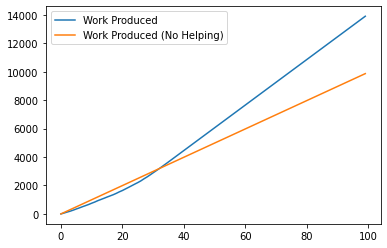

In [684]:
breakdown[["Work Produced", "Work Produced (No Helping)"]].plot()

<AxesSubplot:>

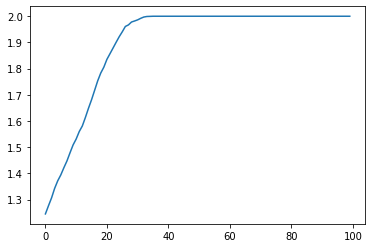

In [685]:
breakdown["Average Ability"].plot()

In [686]:
print('Final Timestep:')
breakdown.iloc[-1]

Final Timestep:


Work Produced                 13898.275967
Work Produced (No Helping)     9864.079090
Average Ability                   2.000000
Name: 99, dtype: float64